In [82]:
import os
import sys
from subprocess import check_call
from datetime import datetime
from glob import glob

import xarray as xr
import numpy as np

PACKAGE_DIR = os.path.dirname(os.getcwd())
sys.path.append(PACKAGE_DIR)

batch=datetime(2023, 7, 30, 12)
step = 240
var = '2t'

## Convert Ensemble Forecast to Deterministic

> This section will demonstrates several routes converting ensemble <br>
> forecast to deterministic forecast. The example code will use<br>
> cdo (climate data operator) command to the transform the ensemble data. <br>

## 1. Use Control Forecast

> Directly use the control forecast as deterministic forecast. Using<br> 
> cdo sellevel to select the control forecast run (number=0). <br>
> (This method is the easiest way, but it doesn't utilize all the <br>
> ensemble member data.)

In [45]:
ens_nc = os.path.join(PACKAGE_DIR, f'data/{"ecmwf-enfo"}-{batch:%Y%m%d%H}-{step:02}-{var}.nc')
cf_nc = os.path.join(PACKAGE_DIR, f'data/{"ecmwf-enfo"}-{batch:%Y%m%d%H}-{step:02}-{var}-cf.nc')
check_call(f'cdo -f nc4 -z zip4 sellevel,0 {ens_nc} {cf_nc}', shell=True)

cdi  warning (cdfScanVarAttr): NetCDF: Variable not found - >step<
cdi  warning (cdfScanVarAttr): NetCDF: Variable not found - >heightAboveGround<
cdi  warning (cdfInqContents): Coordinates variable number can't be assigned!


0

In [10]:
ds = xr.open_dataset(cf_nc)
ds

<xarray.Dataset>
Dimensions:    (time: 1, longitude: 900, latitude: 451, number: 1)
Coordinates:
  * time       (time) datetime64[ns] 2023-08-09T12:00:00
  * longitude  (longitude) float64 -180.0 -179.6 -179.2 ... 178.8 179.2 179.6
  * latitude   (latitude) float64 90.0 89.6 89.2 88.8 ... -89.2 -89.6 -90.0
  * number     (number) float64 0.0
Data variables:
    2t         (time, number, latitude, longitude) float32 ...
Attributes:
    CDI:          Climate Data Interface version 2.2.1 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Wed Aug 02 09:20:20 2023: cdo -f nc -z zip4 sellevel,0 /Use...
    CDO:          Climate Data Operators version 2.2.0 (https://mpimet.mpg.de...

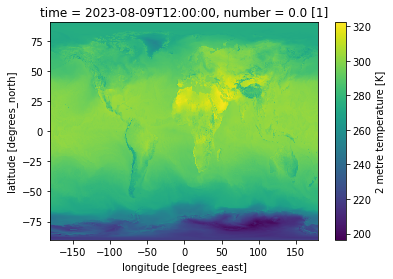

In [12]:
ds['2t'].plot()

In [42]:
check_call(f'cdo info {cf_nc}', shell=True)

    -1 :       Date     Time   Level Gridsize    Miss :     Minimum        Mean     Maximum : Parameter ID
     1 : 2023-08-09 12:00:00       0   405900       0 :      196.33      281.20      322.21 : -1            


0

## 2. Use Ensemble Statistic

> In order to take the advantage of ensemble forecast, using the ensemble<br> 
> statistic is more recommendable in converting to deterministic forecast.

### 2.1 Ensemble Mean

> Ensemble mean is easy to calculate and is effective to summarize the<br>
> majority feature of the meteo variable at the forecast time. With cdo, it<br>
> can be done by direclty call the operator vertmean, which will calculate<br>
> the level mean of the input data (in this context level is the run number<br> 
> dimension).<br>
> <br>
> !!! Notice that this method can only be apply to those variable with symmetric<br> 
> gaussian distribution like temperature, dewpoint temperature, pressure,<br> 
> geopotential. 

In [46]:
mean_nc = os.path.join(PACKAGE_DIR, f'data/{"ecmwf-enfo"}-{batch:%Y%m%d%H}-{step:02}-{var}-mean.nc')
check_call(f'cdo -f nc4 -z zip4 vertmean {ens_nc} {mean_nc}', shell=True)

cdi  warning (cdfScanVarAttr): NetCDF: Variable not found - >step<
cdi  warning (cdfScanVarAttr): NetCDF: Variable not found - >heightAboveGround<
cdi  warning (cdfInqContents): Coordinates variable number can't be assigned!
cdo    vertmean (Warning): Layer bounds not available, using constant vertical weights for variable 2t!


0

In [17]:
ds = xr.open_dataset(mean_nc)
ds

<xarray.Dataset>
Dimensions:    (time: 1, longitude: 900, latitude: 451)
Coordinates:
  * time       (time) datetime64[ns] 2023-08-09T12:00:00
  * longitude  (longitude) float64 -180.0 -179.6 -179.2 ... 178.8 179.2 179.6
  * latitude   (latitude) float64 90.0 89.6 89.2 88.8 ... -89.2 -89.6 -90.0
Data variables:
    2t         (time, latitude, longitude) float32 ...
Attributes:
    CDI:          Climate Data Interface version 2.2.1 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Wed Aug 02 09:27:42 2023: cdo -f nc -z zip4 vertmean /Users...
    CDO:          Climate Data Operators version 2.2.0 (https://mpimet.mpg.de...

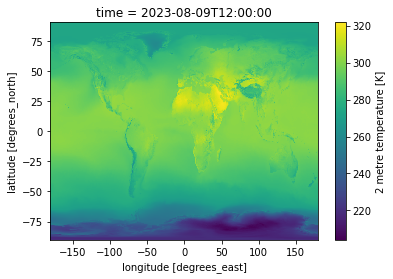

In [18]:
ds['2t'].plot()

In [36]:
check_call(f'cdo info {mean_nc}', shell=True)

    -1 :       Date     Time   Level Gridsize    Miss :     Minimum        Mean     Maximum : Parameter ID
     1 : 2023-08-09 12:00:00       0   405900       0 :      204.10      281.48      321.67 : -1            


0

### 2.2 Ensemble Median

> Ensemble median can be used to describes the value lying on the center<br>
> of all ensemble members. It's suitable for the varibales with skewed<br>
> distributions like precipitation, windspeed. To compute ensemble median,<br>
> it's recommendable to split the file with forecast number with splitlevel <br>
> and then calculate the ens percentile with enspctl.<br>

In [39]:
split_nc = os.path.join(PACKAGE_DIR, f'data/{"ecmwf-enfo"}-{batch:%Y%m%d%H}-{step:02}-{var}-split')
percentile50_nc = os.path.join(PACKAGE_DIR, f'data/{"ecmwf-enfo"}-{batch:%Y%m%d%H}-{step:02}-{var}-p50.nc')

In [26]:
check_call(f'cdo -f nc4 splitlevel {ens_nc} {split_nc}', shell=True)

cdi  warning (cdfScanVarAttr): NetCDF: Variable not found - >step<
cdi  warning (cdfScanVarAttr): NetCDF: Variable not found - >heightAboveGround<
cdi  warning (cdfInqContents): Coordinates variable number can't be assigned!


0

In [37]:
check_call(f'cdo -f nc4 enspctl,50 {" ".join(glob(split_nc + "*"))} {percentile50_nc}', shell=True)

cdo    enspctl (Warning): Input parameters have different levels!
cdo    enspctl (Warning): Input parameters have different levels!
cdo    enspctl (Warning): Input parameters have different levels!
cdo    enspctl (Warning): Input parameters have different levels!
cdo    enspctl (Warning): Input parameters have different levels!
cdo    enspctl (Warning): Input parameters have different levels!
cdo    enspctl (Warning): Input parameters have different levels!
cdo    enspctl (Warning): Input parameters have different levels!
cdo    enspctl (Warning): Input parameters have different levels!
cdo    enspctl (Warning): Input parameters have different levels!
cdo    enspctl (Warning): Input parameters have different levels!
cdo    enspctl (Warning): Input parameters have different levels!
cdo    enspctl (Warning): Input parameters have different levels!
cdo    enspctl (Warning): Input parameters have different levels!
cdo    enspctl (Warning): Input parameters have different levels!
cdo    ens

0

In [38]:
check_call(f'cdo info {percentile50_nc}', shell=True)

    -1 :       Date     Time   Level Gridsize    Miss :     Minimum        Mean     Maximum : Parameter ID
     1 : 2023-08-09 12:00:00      25   405900       0 :      202.98      281.49      322.07 : -1            


0

### 2.3 Ensemble Maximum/Minimum

> Ensemble maximum/minimum can also be transformed to deterministic<br>
> forecast. It could be used to estimated the extreme wrongest/best<br> 
> situation. Using vertmax/vertmin in cdo can achive easily. 

In [50]:
# max / min
max_nc = os.path.join(PACKAGE_DIR, f'data/{"ecmwf-enfo"}-{batch:%Y%m%d%H}-{step:02}-{var}-max.nc')
min_nc = os.path.join(PACKAGE_DIR, f'data/{"ecmwf-enfo"}-{batch:%Y%m%d%H}-{step:02}-{var}-min.nc')

check_call(f'cdo -f nc4 -z zip4 -vertmax {ens_nc} {max_nc}', shell=True)
check_call(f'cdo -f nc4 -z zip4 -vertmin {ens_nc} {min_nc}', shell=True)

cdi  warning (cdfScanVarAttr): NetCDF: Variable not found - >step<
cdi  warning (cdfScanVarAttr): NetCDF: Variable not found - >heightAboveGround<
cdi  warning (cdfInqContents): Coordinates variable number can't be assigned!
cdi  warning (cdfScanVarAttr): NetCDF: Variable not found - >step<
cdi  warning (cdfScanVarAttr): NetCDF: Variable not found - >heightAboveGround<
cdi  warning (cdfInqContents): Coordinates variable number can't be assigned!


0

In [48]:
check_call(f'cdo info {max_nc}', shell=True)

    -1 :       Date     Time   Level Gridsize    Miss :     Minimum        Mean     Maximum : Parameter ID
     1 : 2023-08-09 12:00:00       0   405900       0 :      214.98      285.75      325.21 : -1            


0

In [51]:
check_call(f'cdo info {min_nc}', shell=True)

    -1 :       Date     Time   Level Gridsize    Miss :     Minimum        Mean     Maximum : Parameter ID
     1 : 2023-08-09 12:00:00       0   405900       0 :      188.84      277.02      318.57 : -1            


0

> If the run number of the ensemble of maximum/minimum is needed (to get <br>
> the storyline of maximum/minimum), it can be calculated by masking the value<br>
> not less than maximum(not greater than minimum). 

In [59]:
maxmask_nc = os.path.join(PACKAGE_DIR, f'data/{"ecmwf-enfo"}-{batch:%Y%m%d%H}-{step:02}-{var}-maxmask.nc')
check_call(f'cdo -ge {ens_nc} {max_nc} {maxmask_nc}', shell=True)

cdi  warning (cdfScanVarAttr): NetCDF: Variable not found - >step<
cdi  warning (cdfScanVarAttr): NetCDF: Variable not found - >heightAboveGround<
cdi  warning (cdfInqContents): Coordinates variable number can't be assigned!


cdo    ge: Filling up stream2 >/Users/blizhan/Documents/GitHub/ensabc/data/ecmwf-enfo-2023073012-240-2t-max.nc< by copying the first record.


0

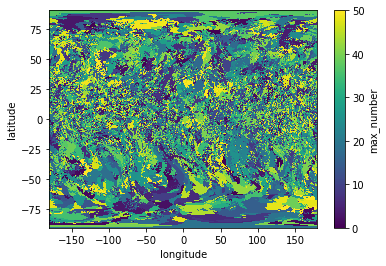

In [260]:
ds = xr.open_dataset(maxmask_nc)

# get number where data == 1
val = np.array(ds[var].values)
for i in range(ds['number'].shape[0]):
    num = int(ds['number'][i].values)
    tmp = val[0,i,:,:]
    if i == 0:
        number = np.ones_like(tmp)*np.nan
    number = np.where(tmp==1, num, number)

da = xr.DataArray(
    data=number,
    dims=['latitude','longitude'],
    coords=dict(
        latitude=(['latitude',], ds.latitude.values),
        longitude=(['longitude'], ds.longitude.values),
    ),
)
ds = da.to_dataset(name='max_number')
ds['max_number'].plot()


cdi  warning (cdfScanVarAttr): NetCDF: Variable not found - >step<
cdi  warning (cdfScanVarAttr): NetCDF: Variable not found - >heightAboveGround<
cdi  warning (cdfInqContents): Coordinates variable number can't be assigned!


cdo    le: Filling up stream2 >/Users/blizhan/Documents/GitHub/ensabc/data/ecmwf-enfo-2023073012-240-2t-min.nc< by copying the first record.


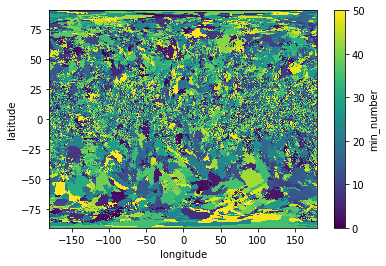

In [263]:
minmask_nc = os.path.join(PACKAGE_DIR, f'data/{"ecmwf-enfo"}-{batch:%Y%m%d%H}-{step:02}-{var}-minmask.nc')
check_call(f'cdo -le {ens_nc} {min_nc} {minmask_nc}', shell=True)

ds = xr.open_dataset(minmask_nc)

val = np.array(ds[var].values)
for i in range(ds['number'].shape[0]):
    num = int(ds['number'][i].values)
    tmp = val[0,i,:,:]
    if i == 0:
        number = np.ones_like(tmp)*np.nan
    number = np.where(tmp==1, num, number)

da = xr.DataArray(
    data=number,
    dims=['latitude','longitude'],
    coords=dict(
        latitude=(['latitude',], ds.latitude.values),
        longitude=(['longitude'], ds.longitude.values),
    ),
)
ds = da.to_dataset(name='min_number')
ds['min_number'].plot()
